#Q1.1 - Model choice and justification

Model: Linear Regression

Library: Statsmodels OLS







I chose Linear Regression because Cook’s Distance is defined for Ordinary Least Squares (OLS) and measures how much the fitted OLS model changes when a single observation is removed.


I chose Statsmodels OLS because it provides built-in influence diagnostics, including Cook’s Distance, leverage, and studentized residuals. This allows Cook’s Distance to be computed directly and correctly, without re-implementing formulas manually.




#Q1.2 - Identify outliers, remove them, and export clean CSV

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('usina_with_outliers.csv')
df.head()

# label independent(X) and dependent(Y) variables
X = df[["AT", "V", "AP", "RH"]]
Y = df[["PE"]]


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size = 0.30,     # 30% test/70% train
    random_state = 42     # fixed random state
)


# Fit an OLS(ordinary least squares)
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()


# Compute cooks distance for each training point
influence = model.get_influence()
cooks_d, pvals = influence.cooks_distance


# Put Cooks_d into a table
cooks_df = pd.DataFrame({
    "index": X_train.index,
    "cooks_d": cooks_d
}).set_index("index")

cooks_df.sort_values("cooks_d", ascending=False).head(10)


# Identify outliers using an appropriate threshold rule
n = X_train.shape[0]
threshold = 4 / n
threshold

# Identify outliers
outlier_idx = cooks_df.index[cooks_df["cooks_d"] > threshold]
len(outlier_idx), outlier_idx[:10]


# remove outliers from spreadsheet
df_clean = df.drop(index = outlier_idx).reset_index(drop=True)
df_clean.shape

# Export the cleaned set
df_clean.to_csv("usina.csv", index=False)


#Q2 - Train/Test Evaluation Before vs After Outlier Removal

In [44]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# train the model and return Train/Test MAE, MSE, R^2
def eval_model(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  return {
      "Train MAE": mean_absolute_error(y_train, pred_train),
      "Train MSE": mean_squared_error(y_train, pred_train),
      "Train R^2": r2_score(y_train, pred_train),
      "Test MAE": mean_absolute_error(y_test, pred_test),
      "Test MSE": mean_squared_error(y_test, pred_test),
      "Test R2": r2_score(y_test, pred_test)
  }




In [45]:
lambdas = [0.01, 0.1, 1 ,10, 100]

def run_all_models(df, random_state=42):
    X = df[["AT", "V", "AP", "RH"]]
    y = df["PE"]

    # 70/30 split, fixed random state
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=random_state
    )

    results = []

    # 1) Linear Regression
    res = eval_model(LinearRegression(), X_train, X_test, y_train, y_test)
    results.append({"Model": "LinearRegression", "lambda": None, **res})

    # 2) Ridge Regression for each lambda
    for lam in lambdas:
        res = eval_model(Ridge(alpha=lam), X_train, X_test, y_train, y_test)
        results.append({"Model": "Ridge", "lambda": lam, **res})

    # 3) Lasso Regression for each lambda
    for lam in lambdas:
        res = eval_model(Lasso(alpha=lam, max_iter=10000), X_train, X_test, y_train, y_test)
        results.append({"Model": "Lasso", "lambda": lam, **res})

    return pd.DataFrame(results)




#Q2.1 - Run on usina_with_outliers.csv

In [46]:
df_out = pd.read_csv("usina_with_outliers.csv")
results_out = run_all_models(df_out, random_state=42)
results_out

,Model,lambda,Train MAE,Train MSE,Train R^2,Test MAE,Test MSE,Test R2
0,LinearRegression,NaN,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
1,Ridge,0.01,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
2,Ridge,0.10,5.198680,123.384207,0.650171,5.052459,125.113392,0.642574
3,Ridge,1.00,5.198685,123.384207,0.650171,5.052463,125.113421,0.642574
4,Ridge,10.00,5.198737,123.384207,0.650171,5.052513,125.113705,0.642573
5,Ridge,100.00,5.199261,123.384213,0.650171,5.053003,125.116548,0.642565
6,Lasso,0.01,5.198858,123.384210,0.650171,5.052626,125.115332,0.642568
7,Lasso,0.10,5.201739,123.384607,0.650169,5.055348,125.134495,0.642514
8,Lasso,1.00,5.229507,123.421151,0.650066,5.083092,125.338356,0.641931
9,Lasso,10.00,5.540418,126.141514,0.642353,5.408803,128.902136,0.631750


#Q2.2 - Run on usina.csv (cleaned)

In [49]:
df_clean = pd.read_csv("usina.csv")
results_clean = run_all_models(df_clean, random_state=42)
results_clean

,Model,lambda,Train MAE,Train MSE,Train R^2,Test MAE,Test MSE,Test R2
0,LinearRegression,NaN,4.069898,59.887427,0.806996,4.013913,40.098111,0.866504
1,Ridge,0.01,4.069898,59.887427,0.806996,4.013913,40.098110,0.866504
2,Ridge,0.10,4.069899,59.887427,0.806996,4.013914,40.098109,0.866504
3,Ridge,1.00,4.069907,59.887427,0.806996,4.013921,40.098097,0.866504
4,Ridge,10.00,4.069987,59.887428,0.806996,4.013988,40.097978,0.866504
5,Ridge,100.00,4.070784,59.887473,0.806995,4.014657,40.096827,0.866508
6,Lasso,0.01,4.069882,59.887430,0.806996,4.013892,40.100439,0.866496
7,Lasso,0.10,4.072011,59.887950,0.806994,4.015638,40.119531,0.866433
8,Lasso,1.00,4.096430,59.944088,0.806813,4.037275,40.358763,0.865636
9,Lasso,10.00,4.580677,64.728845,0.791393,4.526738,46.589091,0.844894


#Q2.3 - Report results clearly (tables)

In [50]:
results_out.sort_values("Test MSE").head(10)
results_clean.sort_values("Test MSE").head(10)

,Model,lambda,Train MAE,Train MSE,Train R^2,Test MAE,Test MSE,Test R2
5,Ridge,100.00,4.070784,59.887473,0.806995,4.014657,40.096827,0.866508
4,Ridge,10.00,4.069987,59.887428,0.806996,4.013988,40.097978,0.866504
3,Ridge,1.00,4.069907,59.887427,0.806996,4.013921,40.098097,0.866504
2,Ridge,0.10,4.069899,59.887427,0.806996,4.013914,40.098109,0.866504
1,Ridge,0.01,4.069898,59.887427,0.806996,4.013913,40.098110,0.866504
0,LinearRegression,NaN,4.069898,59.887427,0.806996,4.013913,40.098111,0.866504
6,Lasso,0.01,4.069882,59.887430,0.806996,4.013892,40.100439,0.866496
7,Lasso,0.10,4.072011,59.887950,0.806994,4.015638,40.119531,0.866433
8,Lasso,1.00,4.096430,59.944088,0.806813,4.037275,40.358763,0.865636
9,Lasso,10.00,4.580677,64.728845,0.791393,4.526738,46.589091,0.844894


# Discussion

**Q: Do outliers change train error? Test error?**

Yes, outliers changed the train error. Outliers increase both training and test error. With outliers present, the model shows much higher MSE and lower R² on both the training and test sets. After removing outliers, both errors drop substantially.

**Q: Which dataset (with outliers vs without outliers) shows better generalization?**

The dataset without outliers shows much better generalization. It has lower test MAE and MSE, higher test R², and a smaller gap between training and test performance, suggesting the model is learning the true underlying relationship rather than being distorted by extreme values.


**Q: Do Ridge/Lasso appear to help relative to standard linear regression?**

Ridge and Lasso do not improve performance compared to standard linear regression for small λ values, as their results are nearly identical. Larger λ values, performance worsens especially for Lasso due to underfitting. Overall, removing outliers has a much larger impact on performance than adding regularization in this case.


# Q3 - Reliability of Coefficients (Use Outlier-Removed Dataset)

#Q3.1 — Method choice and scaling decision

Linear Regression + Statsmodels OLS

**Q: Why did you choose this model (Linear vs Ridge vs Lasso)?**

I chose linear regression because because coefficient “reliability” is assessed using standard errors and t-statistics, which are standard outputs for OLS. Ridge and Lasso shrink coefficients, which can make them more stable but also makes direct “reliability” comparisons harder because the estimates are intentionally biased by regularization.


**Q: Why did you choose this library (Statsmodels vs scikit-learn)?**

I chose Statsmodels OLS because it directly provides coefficient standard errors, t-values, and p-values, which are exactly what we need to evaluate coefficient reliability.

**Q: Would you scale IVs and/or DV for this coefficient reliability task?**

For the independent variables (AT, V, AP, RH), scaling is optional, but for reliability comparison using t-values, scaling is not required because the t-statistic already normalizes the coefficient by its standard error.

# Q3.2 — Implementation and results

In [53]:
# Load outlier-removed dataset
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv("usina.csv")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [55]:
# Define X (Independent) and Y (Dependent)
X = df[["AT", "V", "AP", "RH"]]
y = df["PE"]

# Add intercept and fit OLS
X_sm = sm.add_constant(X)  # adds intercept term
ols_model = sm.OLS(y, X_sm).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 1.114e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        04:17:32   Log-Likelihood:                -32361.
No. Observations:                9483   AIC:                         6.473e+04
Df Residuals:                    9478   BIC:                         6.477e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        255.9564     14.780     17.318      0.0

In [56]:
coef_table = pd.DataFrame({
    "coef": ols_model.params,
    "std_err": ols_model.bse,
    "t_value": ols_model.tvalues,
    "p_value": ols_model.pvalues
})

# Only keep the predictor coefficients (exclude intercept/const)
coef_table_no_intercept = coef_table.drop(index="const")
coef_table_no_intercept.sort_values("t_value", key=lambda s: s.abs(), ascending=False)

,coef,std_err,t_value,p_value
AT,-1.701732,0.021702,-78.413588,0.000000e+00
V,-0.246664,0.010519,-23.448616,3.036546e-118
RH,-0.112194,0.006303,-17.799339,9.689123e-70
AP,0.250178,0.014355,17.428296,5.539123e-67


In [57]:
abs_t = coef_table_no_intercept["t_value"].abs()

most_reliable = abs_t.idxmax()
least_reliable = abs_t.idxmin()

most_reliable, least_reliable

print("Most reliable coefficient:", most_reliable)
print(coef_table_no_intercept.loc[most_reliable])

print("\nLeast reliable coefficient:", least_reliable)
print(coef_table_no_intercept.loc[least_reliable])

Most reliable coefficient: AT
coef       -1.701732
std_err     0.021702
t_value   -78.413588
p_value     0.000000
Name: AT, dtype: float64

Least reliable coefficient: AP
coef       2.501782e-01
std_err    1.435471e-02
t_value    1.742830e+01
p_value    5.539123e-67
Name: AP, dtype: float64


# Results

I measured coefficient reliability by using t-values (and standard errors) from Statsmodels OLS. A coefficient is more reliable if it has a large |t-value| (large effect relative to its uncertainty) and a small p-value. A coefficient is less reliable if it has a small |t-value|, meaning the estimate is noisy/unstable relative to its size (often due to multicollinearity or weak relationship with the target).

#Q4 - Most Important vs Least Important Features (Use Outlier-Removed Dataset)

# 4.1 — Method choice and scaling decision

I chose Ridge Regression + scikit-learn

**Q: Why did you choose this model (Linear vs Ridge vs Lasso)?**

I chose Ridge Regression because feature importance is based on coefficients can be unstable when predictors are correlated. Ridge helps by shrinking coefficients and making them more stable, while still keeping all features in the model (unlike Lasso, which may zero out features).


**Q: Why did you choose this library (Statsmodels vs scikit-learn)?**

I chose scikit-learn because it makes it easy to scale features correctly using a pipeline,try multiple λ values quickly, and pick the best λ based on test performance.


**Would you scale IVs and/or DV for this feature importance task?**

Yes I will scale the IVs. I won't scale DV for this task.

# Q4.2 — Implementation and results

In [60]:
# Load the outlier-removed dataset
df = pd.read_csv("usina.csv")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [61]:
# define fetures (IV) and target (DV)
features = ["AT", "V", "AP", "RH"]
X = df[features]
y = df["PE"]

In [62]:
# 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [66]:
lambdas = [0.01, 0.1, 1, 10, 100]

ridge_results = []

for lam in lambdas:
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),     # scale IVs only
        ("model", Ridge(alpha=lam))
    ])

    ridge_pipe.fit(X_train, y_train)
    preds = ridge_pipe.predict(X_test)

    ridge_results.append({
        "lambda": lam,
        "Test MSE": mean_squared_error(y_test, preds),
        "Test MAE": mean_absolute_error(y_test, preds),
        "Test R^2": r2_score(y_test, preds)
    })

ridge_results_df = pd.DataFrame(ridge_results).sort_values("Test MSE")
ridge_results_df

,lambda,Test MSE,Test MAE,Test R^2
3,10.00,40.095895,4.018811,0.866511
2,1.00,40.097761,4.014401,0.866505
1,0.10,40.098074,4.013962,0.866504
0,0.01,40.098107,4.013918,0.866504
4,100.00,40.182770,4.068651,0.866222


In [67]:
best_lambda = ridge_results_df.iloc[0]["lambda"]
best_lambda

np.float64(10.0)

In [74]:
best_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=best_lambda))
])

best_ridge.fit(X_train, y_train)

coefs = best_ridge.named_steps["model"].coef_
coef_series = pd.Series(coefs, index=features)

coef_series

,0
AT,-13.183970
V,-3.096814
AP,1.426800
RH,-1.580195


In [70]:
abs_coef = coef_series.abs()

most_important = abs_coef.idxmax()
least_important = abs_coef.idxmin()

most_important, least_important

('AT', 'AP')

In [71]:
print("Best Ridge lambda:", best_lambda)
print("\nScaled coefficients (Ridge):")
print(coef_series.sort_values(key=lambda s: s.abs(), ascending=False))

print("\nMost important feature:", most_important, "| coefficient:", coef_series[most_important])
print("Least important feature:", least_important, "| coefficient:", coef_series[least_important])

Best Ridge lambda: 10.0

Scaled coefficients (Ridge):
AT   -13.183970
V     -3.096814
RH    -1.580195
AP     1.426800
dtype: float64

Most important feature: AT | coefficient: -13.183970428389554
Least important feature: AP | coefficient: 1.4267996125143532


# Results

I scaled IVs so coefficients are comparable across features. I tuned Ridge λ using the required set and picked the value with best test MSE.


# Q5 - Regularization Paths (Scaled Data, Outlier-Removed Dataset)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso

# load usina dataset
df = pd.read_csv("usina.csv")

features = ["AT", "V", "AP", "RH"]
X = df[features].values
y = df["PE"].values

In [77]:
# train and test data (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [80]:
# sale the IVs
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [81]:
# Choose λ range + create 100 log-spaced values
lambdas = np.logspace(-4, 2, 100)   # 10^-4 to 10^2, 100 values

In [82]:
# Fit Ridge for each λ and record coefficients
ridge_coefs = []

for lam in lambdas:
    model = Ridge(alpha=lam)
    model.fit(X_train_s, y_train)
    ridge_coefs.append(model.coef_)

ridge_coefs = np.array(ridge_coefs)

In [84]:
# Fit Lasso for each λ and record coefficients
lasso_coefs = []

for lam in lambdas:
    model = Lasso(alpha=lam, max_iter=10000)
    model.fit(X_train_s, y_train)
    lasso_coefs.append(model.coef_)

lasso_coefs = np.array(lasso_coefs)

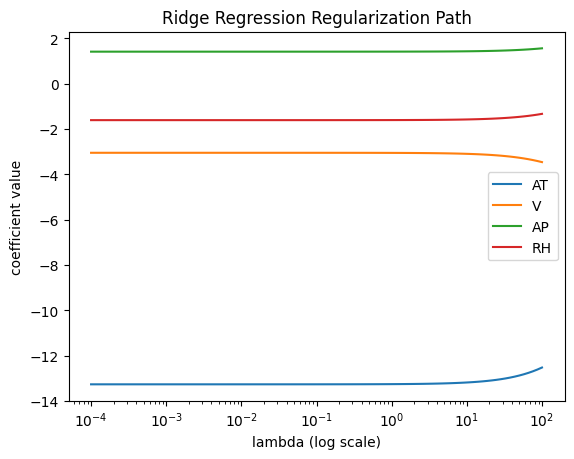

In [85]:
# Plot Reguralization paths
plt.figure()
for j, name in enumerate(features):
    plt.plot(lambdas, ridge_coefs[:, j], label=name)

plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("coefficient value")
plt.title("Ridge Regression Regularization Path")
plt.legend()
plt.show()

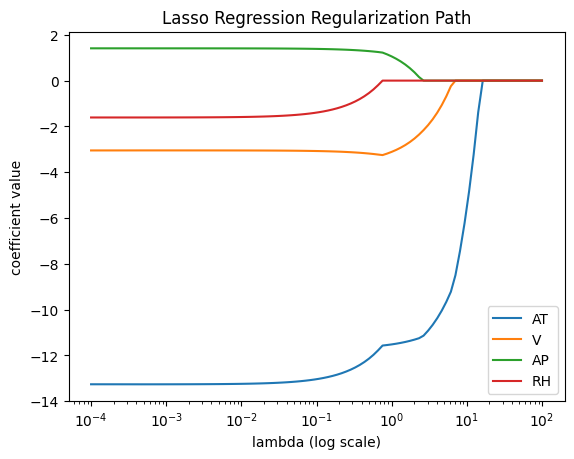

In [86]:
# Lasso Path Plot
plt.figure()
for j, name in enumerate(features):
  plt.plot(lambdas, lasso_coefs[:, j], label=name)
  plt.xscale("log")
plt.xlabel("lambda (log scale)")
plt.ylabel("coefficient value")
plt.title("Lasso Regression Regularization Path")
plt.legend()
plt.show()

# Discussion

**1) What happens to coefficients as λ increases in Ridge vs. Lasso?**

As λ increases, Ridge gradually shrinks all coefficients toward zero, but they usually stay non-zero. Lasso, on the other hand, shrinks coefficients more aggressively and can push some of them exactly to zero, effectively removing those features from the model as regularization increases.

**2) Which regression is better under multicollinearity in the IVs, and why?**

Ridge is better when predictors are highly correlated because it spreads the influence across those variables instead of letting any single coefficient dominate. This stabilizes the estimates and reduces variance, making the model more reliable under multicollinearity.

**3) Which regression is better for feature selection, and why?**

Lasso is better for feature selection because its penalty can force some coefficients to zero. This naturally removes less important features and results in a simpler, more interpretable model.